# NIH Chest X-ray Multi-Label Classification (TensorFlow)

This notebook implements a multi-label classification model for the NIH Chest X-ray dataset using TensorFlow/Keras to detect 14 thoracic diseases plus 'No findings'. It supports local testing (CPU, sample dataset) and Kaggle training (GPU, sample or full dataset).

## Setup
- Dataset: NIH Chest X-ray (sample: 5,606 images, full: 112,120 images)
- Framework: TensorFlow/Keras
- Hardware: Local CPU or Kaggle GPU (T4/P100)

## Steps
1. Load and preprocess data
2. Define dataset generator and model
3. Train with mixed precision
4. Evaluate with AUC-ROC
5. Save model and sync to GitHub

In [3]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# Enable mixed precision for GPU
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Check GPU availability
print('GPUs available:', tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


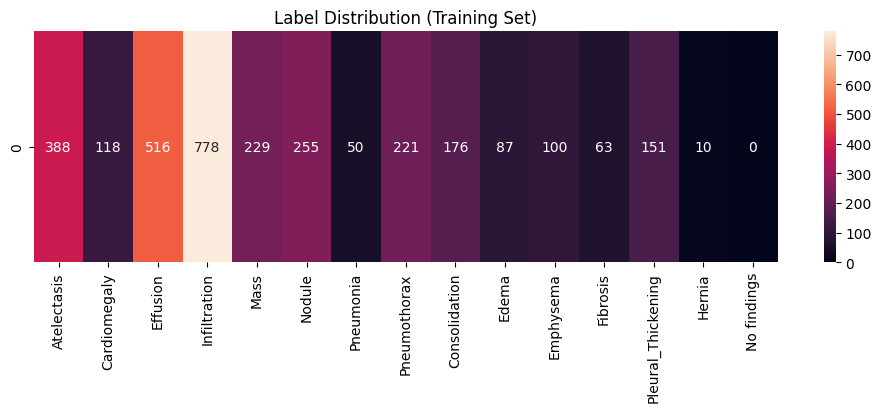

In [7]:
# Conditional data paths
if os.path.exists('/kaggle/input'):
    data_path = '/kaggle/input/sample/sample/sample_labels.csv'
    image_dir = '/kaggle/input/sample/sample/images'
    full_data_path = '/kaggle/input/nih-chest-xrays/data/Data_Entry_2017.csv'
    full_image_dir = '/kaggle/input/nih-chest-xrays/data'
    train_val_list = '/kaggle/input/nih-chest-xrays/data/train_val_list.txt'
else:
    data_path = '/Users/heythere/Downloads/data/sample_labels.csv'
    image_dir = '/Users/heythere/Downloads/data/images'
    full_data_path = 'data/Data_Entry_2017.csv'
    full_image_dir = 'data'
    train_val_list = 'data/train_val_list.txt'
    
# Toggle dataset
use_full_dataset = False

if use_full_dataset:
    data = pd.read_csv(full_data_path)
    with open(train_val_list, 'r') as f:
        train_val_files = f.read().splitlines()
    train_val_data = data[data['Image Index'].isin(train_val_files)]
    train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)
    image_dir = full_image_dir
else:
    data = pd.read_csv(data_path)
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Classes
classes = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
           'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening',
           'Hernia', 'No findings']

def parse_labels(label_string):
    labels = label_string.split('|')
    return [1 if c in labels else 0 for c in classes]

train_data['label_vector'] = train_data['Finding Labels'].apply(parse_labels)
val_data['label_vector'] = val_data['Finding Labels'].apply(parse_labels)

# Label distribution
plt.figure(figsize=(12, 3))
sns.heatmap(np.array(train_data['label_vector'].tolist()).sum(axis=0).reshape(1, -1), xticklabels=classes, annot=True, fmt='.0f')
plt.title('Label Distribution (Training Set)')
plt.show()

In [8]:
def data_generator(data, image_dir, is_full_dataset=False, batch_size=16, img_size=(224, 224), augment=False):
    while True:
        for start in range(0, len(data), batch_size):
            batch_data = data[start:start + batch_size]
            images = []
            labels = []
            for idx in batch_data.index:
                img_name = batch_data.loc[idx, 'Image Index']
                if is_full_dataset:
                    for i in range(1, 13):
                        path = f'{image_dir}/images_{i:03d}/images/{img_name}'
                        if os.path.exists(path):
                            break
                    else:
                        continue  # Skip missing images
                else:
                    path = f'{image_dir}/{img_name}'
                image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    continue
                image = cv2.resize(image, img_size)
                image = image / 255.0
                if augment:
                    if np.random.rand() > 0.5:
                        image = cv2.flip(image, 1)  # Horizontal flip
                    angle = np.random.uniform(-10, 10)
                    M = cv2.getRotationMatrix2D((img_size[0]/2, img_size[1]/2), angle, 1)
                    image = cv2.warpAffine(image, M, img_size)
                image = np.expand_dims(image, axis=-1)  # Add channel dimension
                images.append(image)
                labels.append(batch_data.loc[idx, 'label_vector'])
            if images:  # Only yield if batch is non-empty
                yield np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)

# Subset for local testing
train_subset = train_data.head(100) if not tf.config.list_physical_devices('GPU') else train_data
val_subset = val_data.head(20) if not tf.config.list_physical_devices('GPU') else val_data

# Generators
batch_size = 64 if tf.config.list_physical_devices('GPU') else 16
train_gen = data_generator(train_subset, image_dir, is_full_dataset=use_full_dataset, batch_size=batch_size, augment=True)
val_gen = data_generator(val_subset, image_dir, is_full_dataset=use_full_dataset, batch_size=batch_size, augment=False)

# Dataset objects
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_subset, image_dir, is_full_dataset=use_full_dataset, batch_size=batch_size, augment=True),
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 1], [None, 15])
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_subset, image_dir, is_full_dataset=use_full_dataset, batch_size=batch_size, augment=False),
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 1], [None, 15])
).prefetch(tf.data.AUTOTUNE)

2025-08-12 12:48:15.095439: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-08-12 12:48:15.095553: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-12 12:48:15.095597: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-08-12 12:48:15.096239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-12 12:48:15.096863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


def build_model(num_classes=15):
    inputs = layers.Input(shape=(224, 224, 1))
    x = layers.Concatenate()([inputs, inputs, inputs])  # 1 → 3 channels
    
    base_model = applications.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3)  # must be 3 channels
    )
    base_model.trainable = True

    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model = build_model()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ concatenate_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │      1,935 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,851,919 (90.99 MB)

 Trainable params: 23,798,799 (90.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 638s 9s/step - accuracy: 0.1266 - loss: 0.2421 - val_accuracy: 0.0772 - val_loss: 0.2565
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 670s 9s/step - accuracy: 0.1417 - loss: 0.2246 - val_accuracy: 0.1195 - val_loss: 0.2655
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 617s 9s/step - accuracy: 0.1474 - loss: 0.2139 - val_accuracy: 0.0772 - val_loss: 0.4880
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 691s 10s/step - accuracy: 0.1623 - loss: 0.2009 - val_accuracy: 0.6434 - val_loss: 0.3146
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 637s 9s/step - accuracy: 0.1828 - loss: 0.1993 - val_accuracy: 0.0772 - val_loss: 0.2867


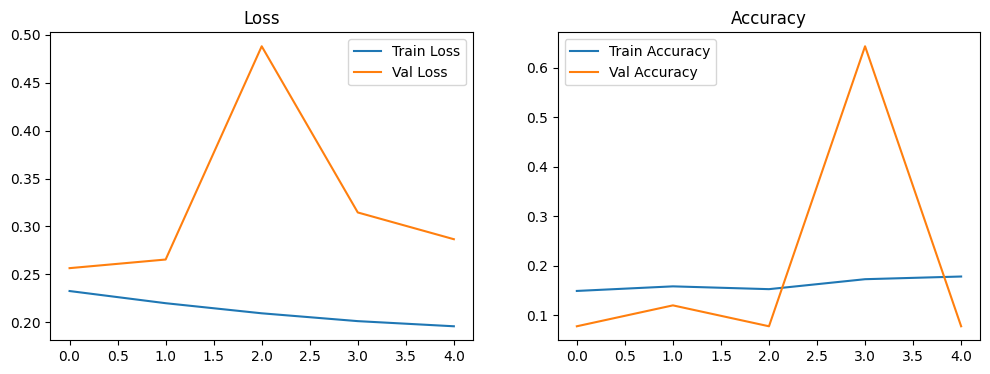

In [13]:
num_epochs = 5 if tf.config.list_physical_devices('GPU') else 2
steps_per_epoch = len(train_subset) // batch_size
validation_steps = len(val_subset) // batch_size

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [14]:
# Evaluate AUC-ROC
all_preds, all_labels = [], []
for images, labels in val_dataset.take(validation_steps):
    preds = model.predict(images, verbose=0)
    all_preds.append(preds)
    all_labels.append(labels.numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(15)]
print(f'AUC per class: {dict(zip(classes, auc_scores))}')

AUC per class: {'Atelectasis': 0.5170456092579986, 'Cardiomegaly': 0.567989936892376, 'Effusion': 0.4537933358608197, 'Infiltration': 0.5617850408548083, 'Mass': 0.48849123849123854, 'Nodule': 0.5049092177582657, 'Pneumonia': 0.4687887236679058, 'Pneumothorax': 0.5367630057803469, 'Consolidation': 0.5297087540682633, 'Edema': 0.5656605125199441, 'Emphysema': 0.42557583659278575, 'Fibrosis': 0.37043966323666977, 'Pleural_Thickening': 0.5400564440263406, 'Hernia': 0.20952380952380953, 'No findings': nan}


2025-08-12 14:50:18.811973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/opt/anaconda3/envs/NNDL/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
model.save('model.h5')